In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from pprint import pprint
import astropy
from astropy import units as u
from scipy.optimize import minimize
from scipy.stats import linregress
print astropy.__version__
import math
import emcee
import corner
import pandas as pd

import matplotlib 
%matplotlib notebook

from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

import winsound

import time

winsound.Beep(440,1500)

2.0.2


In [72]:
class spectral_order:
    def __init__(self,wav,flux,error,order_number):
        self.order = order_number
        self.wav = wav
        self.flux_ergs = flux
        self.flux_watts = flux*10.
        self.error_ergs = error
        self.error_watts = error*10.
        self.snr = flux/error
        
        self.wavfluxmap = {wav[i]: flux[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.waverrmap = {wav[i]: error[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.wavsnrmap = {wav[i]: self.snr[i] for i in range(len(wav)) if not math.isnan(wav[i])}

class arcoiris_merged_spectrum(object):
    def __init__(self, name, data, date):
        self.objectname = name
        self.obsdate = date
        
        tempwav = []
        tempflux = []
        temperr = []
        #tempsnr = []
        
        for line in data:
            conts = line.split()
            tempwav.append(float(conts[0]))
            tempflux.append(float(conts[1]))
            temperr.append(float(conts[2]))
            
        self.wav = np.array(tempwav)
        self.flux = np.array(tempflux)
        self.err = np.array(temperr)
        self.snr = self.flux/self.err
        
        self.flux_watts = self.flux*10.
        self.err_watts = self.err*10.
        
    def __str__(self):
        s = 'Wav Flux Err \n'
        for i in range(self.wav.size):
            s = s + str(self.wav[i]) + ' ' + str(self.flux[i]) + ' ' + str(self.err[i]) + '\n'
            
        return s
        
        
class spex_spectrum(object):
    def __init__(self, data):
        
        first_row_found = False
        first_row_index = -1
        linecount = 0
        while not first_row_found:
            if data[linecount][0] == '#':
                linecount += 1
            else:
                first_row_index = linecount
                first_row_found = True
                
        print 'First row found:', first_row_index
       
        spectral_data = data[first_row_index:]

        full_wavelength_list = []
        full_flux_density_list = []
        full_error_list = []        
        short_wavelength_list = []
        short_flux_density_list = []
        short_error_list = []
        long_wavelength_list = []
        long_flux_density_list = []
        long_error_list = []

        
        for line in spectral_data:
            comps = line.split()
            wav = float(comps[0])
            flux = float(comps[1])
            error = float(comps[2])
        
            if (wav < -900.) or (flux < -900.) or (error < -900.):
                continue

            full_wavelength_list.append(float(comps[0]))
            full_flux_density_list.append(float(comps[1]))
            full_error_list.append(float(comps[2]))
            
            if wav < 2.75:
                short_wavelength_list.append(float(comps[0]))
                short_flux_density_list.append(float(comps[1]))
                short_error_list.append(float(comps[2]))
            else:
                long_wavelength_list.append(float(comps[0]))
                long_flux_density_list.append(float(comps[1]))
                long_error_list.append(float(comps[2]))                
        
        self.full_wavelength = np.array(full_wavelength_list)
        self.full_flux_density = np.array(full_flux_density_list)
        self.full_error = np.array(full_error_list)
        
        self.short_wavelength = np.array(short_wavelength_list)
        self.short_flux_density = np.array(short_flux_density_list)
        self.short_error = np.array(short_error_list)
        self.long_wavelength = np.array(long_wavelength_list)
        self.long_flux_density = np.array(long_flux_density_list)
        self.long_error = np.array(long_error_list)
    
        return
    
class arcoiris_spectrum(object):
    def __init__(self, name, data, date):
        ordernames = ['order3','order4','order5','order6','order7','order8']

        times_order_has_been_read = 0
        orders_read = 0
        ordernumbers = [3,4,5,6,7,8]
        
        orderwav = []
        orderflux = []
        ordererr = []
        
        fullwav = []
        fullflux = []
        fullerr = []
        
        for line in data: 
            if 'Order' in line:
                times_order_has_been_read += 1
                if times_order_has_been_read > 1:
                    orders_read += 1
                ordernumber = ordernumbers[orders_read]
                #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
                if len(orderwav) > 0:
                    orderwavvec = np.array(orderwav)
                    orderfluxvec = np.array(orderflux)
                    ordererrvec = np.array(ordererr)
                    
                    #print ordernames[orders_read-1]
                    setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                    
                    orderwav = []
                    orderflux = []
                    ordererr = []
                    
            else:
                conts = line.split()
                orderwav.append(float(conts[0]))
                orderflux.append(float(conts[1]))
                ordererr.append(float(conts[2]))
                fullwav.append(float(conts[0]))
                fullflux.append(float(conts[1]))
                fullerr.append(float(conts[2]))
                
                
        #print 'Out of loop'
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        orders_read += 1
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        
        setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                
        self.orderlist = [self.order3, self.order4, self.order5, self.order6, self.order7, self.order8]
        
        self.fullwav = np.array(fullwav)
        self.fullflux = np.array(fullflux)
        self.fullerr = np.array(fullerr)
        self.fullsnr = self.fullflux/self.fullerr
        
        self.objectname = name
        self.objectdate = date
        
        
                
    def plot_spectrum(self,snrthreshold,use_watts,temp_spec=None,f=None):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        for order in self.orderlist:
            orderwav_plot = []
            orderflux_plot = []
            for i in range(len(order.wav)):
                if order.snr[i] > snrthreshold:
                    orderwav_plot.append(order.wav[i])
                    if use_watts:
                        orderflux_plot.append(order.flux_watts[i])
                    else:
                        orderflux_plot.append(order.flux_ergs[i])
            ax.plot(orderwav_plot, orderflux_plot)

        if temp_spec != None:
            ax.plot(temp_spec.short_wavelength,temp_spec.short_flux_density*f)            
            
        ax.set_xlim([0.8,2.4])
        
        #if use_watts:
        #    ax.set_ylim([0.,1.e-13])
        #else:
        #    ax.set_ylim([0.,1.e-14])
        
        ax.set_xlabel(r'Wavelength ($\mu$m)')
        if use_watts:
            ax.set_ylabel(r'Flux ($W/m^{2}/\mu m$)')
        else:
            ax.set_ylabel(r'Flux ($ergs s^{-1} cm^{-2} \AA^{-1}$)')
        
        if temp_spec != None:
            ax.set_title(r'Comparison of ' + self.objectname + ' to template')
        else:
            ax.set_title(self.objectname)
            
            
        return fig

class continuum_spectrum(object):
    def __init__(self, data, is_normalized):
        
        first_row_found = False
        first_row_index = -1
        linecount = 0
        while not first_row_found:
            if data[linecount][0] == '#':
                linecount += 1
            else:
                first_row_index = linecount
                first_row_found = True
                
        print 'First row found:', first_row_index
       
        spectral_data = data[first_row_index:]

        wavelength_list = []
        flux_density_list = []
        #full_error_list = []        
        #short_wavelength_list = []
        #short_flux_density_list = []
        #short_error_list = []
        #long_wavelength_list = []
        #long_flux_density_list = []
        #long_error_list = []

        
        for line in spectral_data:
            comps = line.split()
            wav = float(comps[0])
            flux = float(comps[1])
            #error = float(comps[2])
        
            #if (wav < -900.) or (flux < -900.) or (error < -900.):
            #    continue

            wavelength_list.append(float(comps[0]))
            flux_density_list.append(float(comps[1]))
            #full_error_list.append(float(comps[2]))
            
            #if wav < 2.75:
            #    short_wavelength_list.append(float(comps[0]))
            #    short_flux_density_list.append(float(comps[1]))
            #    short_error_list.append(float(comps[2]))
            #else:
            #    long_wavelength_list.append(float(comps[0]))
            #    long_flux_density_list.append(float(comps[1]))
            #    long_error_list.append(float(comps[2]))                
        
        self.wavelength = np.array(wavelength_list)
        self.flux_density = np.array(flux_density_list)
        self.is_normalized = is_normalized
        #self.full_error = np.array(full_error_list)
        
        #self.short_wavelength = np.array(short_wavelength_list)
        #self.short_flux_density = np.array(short_flux_density_list)
        #self.short_error = np.array(short_error_list)
        #self.long_wavelength = np.array(long_wavelength_list)
        #self.long_flux_density = np.array(long_flux_density_list)
        #self.long_error = np.array(long_error_list)
    
        return
    
class high_snr_spectrum(object):
    def __init__(self,input_spectrum,snrthreshold):
        self.wav = np.array([input_spectrum.wav[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        self.flux = np.array([input_spectrum.flux[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        self.err = np.array([input_spectrum.err[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        
        return
        
class high_snr_watts_spectrum(object):
    def __init__(self,input_spectrum,snrthreshold):
        self.wav = np.array([input_spectrum.wav[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        self.flux_watts = np.array([input_spectrum.flux_watts[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        self.err_watts = np.array([input_spectrum.err_watts[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        
        return

In [73]:
def import_arcoiris_from_text(filename, name, date):
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_merged_spectrum(name, data, date)
    
    return spectrum

def import_spex_spectrum_from_file(filename):
    
    with open(filename) as f:
        imported_data = f.readlines()
        
    spectrum = spex_spectrum(imported_data)
    return spectrum

def import_arcoiris_spectrum_from_file(targetname, filename, date):
    
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_spectrum(targetname, data, date)
    
    return spectrum

def import_continuum_spectrum_from_file(filename,is_normalized):
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = continuum_spectrum(data,is_normalized)
    return spectrum

In [26]:
def get_snr_cut_spectrum(spectrum,snrthreshold):
        
    cut_spectrum = high_snr_spectrum(spectrum,snrthreshold)        
    return cut_spectrum
    
def get_snr_cut_spectrum_watts(spectrum,snrthreshold):
        
    cut_spectrum = high_snr_watts_spectrum(spectrum,snrthreshold)        
    return cut_spectrum

In [4]:
awi0005x3s_20171104_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20171104_remerged.txt','AWI0005x3s','2017-11-04')
awi0005x3s_20180301_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20180301_remerged.txt','AWI0005x3s','2018-03-01')
awi0005x3s_20180302_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20180302_remerged.txt','AWI0005x3s','2018-03-02')

awi0005x3s_20171104_2massweighted_merged = import_arcoiris_from_text('awi0005x3s_xtc_20171104_2massweighted_merged.txt','AWI0005x3s','2017-11-04')

template_spectrum = import_spex_spectrum_from_file('M5V_Gl866ABC.txt')

First row found: 47


In [58]:
awi0005x3s_20171104_highsnr = get_snr_cut_spectrum_watts(awi0005x3s_20171104_remerged,20.)
awi0005x3s_20180301_highsnr = get_snr_cut_spectrum_watts(awi0005x3s_20180301_remerged,20.)
awi0005x3s_20180302_highsnr = get_snr_cut_spectrum_watts(awi0005x3s_20180302_remerged,20.)

awi0005x3s_20171104_2mass_highsnr = get_snr_cut_spectrum_watts(awi0005x3s_20171104_2massweighted_merged,20.)


<IPython.core.display.Javascript object>


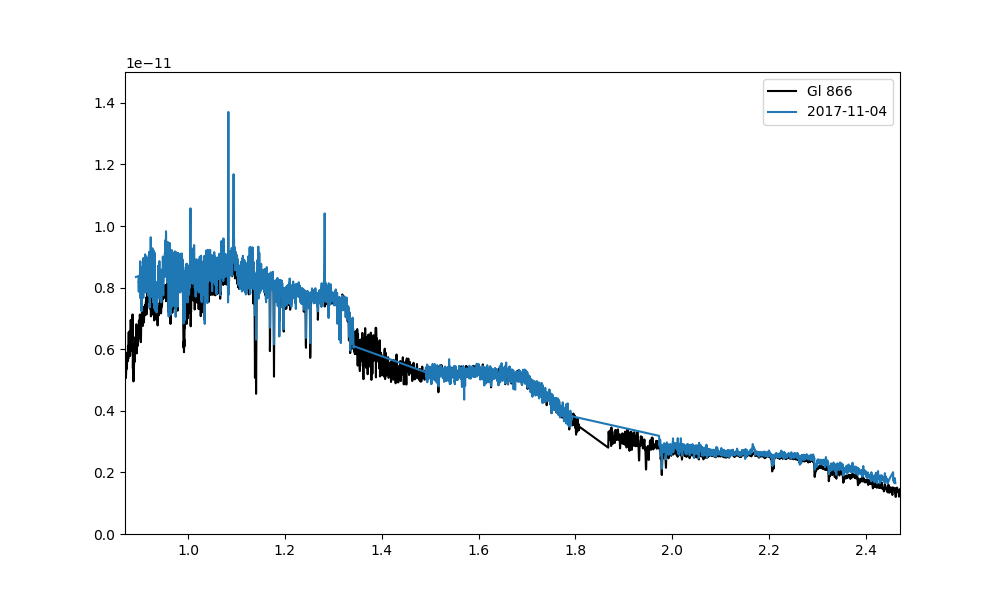

In [30]:
plt.figure(figsize=(10.,6.))

plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts/0.00245,label='2017-11-04')
#plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts*380.,label='2018-03-01')
#plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts*410.,label='2018-03-02')

wav_20171104_angstroms = awi0005x3s_20171104_highsnr.wav*10000.
wav_20180301_angstroms = awi0005x3s_20180301_highsnr.wav*10000.
wav_20180302_angstroms = awi0005x3s_20180302_highsnr.wav*10000.

wav_20171104_2mass_angstroms = awi0005x3s_20171104_2mass_highsnr.wav*10000.

#bb_20171104 = blackbody_lambda(wav_20171104_angstroms * u.AA, 1071.) #* np.pi * u.sr * u.cm * u.cm * u.s / u.erg * wav_20171104_angstroms * u.AA / awi0005x3s_20171104_remerged.wav

#print max(bb_20171104)

#print max(bb_20171104*0.11)

#plt.plot(awi0005x3s_20171104_highsnr_wav, bb_20171104*0.11)

plt.xlim([0.87,2.47])
plt.ylim([0.,1.5e-11])

plt.legend(loc='upper right')

plt.show()

In [7]:
#awi0005x3s_20171104_remerged_wav_angstroms = awi0005x3s_20171104_remerged.wav * 10000.

#stellar radius in meters
rstar = 0.30 * 695700000.

#distance from trig. parallax, in meters
dstar = (1000./9.8599) * 3.08567758149137e16

rdstar = (rstar**2)/(dstar**2)

print rdstar

Tdisk = 1071.
Tstar = 3050.

Tratio = (Tdisk/Tstar)**4

print Tratio

max_xdisk = 0.11 / Tratio * rdstar

print max_xdisk

bestfit_xdisk = 0.054 / Tratio * rdstar

print bestfit_xdisk

test_xdisk = 0.10 /Tratio * rdstar

template_wav_angstroms = template_spectrum.short_wavelength * 10000.

awi0005x3s_20171104_2mass_merged_blackbody = blackbody_lambda(wav_20171104_2mass_angstroms, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20171104_2mass_angstroms_trunclong = np.array([x for x in wav_20171104_2mass_angstroms if x > (2.285e4)])
awi0005x3s_20171104_2mass_merged_blackbody_trunclong = blackbody_lambda(wav_20171104_2mass_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20171104_2mass_merged_blackbody_trunclong_dict = {wav_20171104_2mass_angstroms_trunclong[i]: awi0005x3s_20171104_2mass_merged_blackbody_trunclong[i] for i in range(awi0005x3s_20171104_2mass_merged_blackbody_trunclong.size)}

awi0005x3s_20171104_2mass_merged_blackbody_trunclong_plotting = np.zeros(wav_20171104_2mass_angstroms.size)
for i in range(wav_20171104_2mass_angstroms.size):
    if wav_20171104_2mass_angstroms[i] > 2.285e4:
        awi0005x3s_20171104_2mass_merged_blackbody_trunclong_plotting[i] = awi0005x3s_20171104_2mass_merged_blackbody_trunclong_dict[wav_20171104_2mass_angstroms[i]]

template_wav_angstroms_trunclong = np.array([x for x in template_wav_angstroms if x > (2.285e4)])
template_blackbody_trunclong = blackbody_lambda(template_wav_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

template_blackbody_trunclong_dict = {template_wav_angstroms_trunclong[i]: template_blackbody_trunclong[i] for i in range(template_blackbody_trunclong.size)}

template_blackbody_trunclong_plotting = np.zeros(template_wav_angstroms.size)
for i in range(template_wav_angstroms.size):
    if template_wav_angstroms[i] > 2.285e4:
        template_blackbody_trunclong_plotting[i] = template_blackbody_trunclong_dict[template_wav_angstroms[i]]


print max(awi0005x3s_20171104_2mass_merged_blackbody)

4.44764838653e-21
0.015204023281
3.21784118241e-20
1.57966748955e-20
5.18550045273e-16


In [8]:
test_xdisk_20180301 = 0.11 / Tratio * rdstar

awi0005x3s_20180301_blackbody = blackbody_lambda(wav_20180301_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180301 * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_20180301_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180301 * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20180301_angstroms_trunclong = np.array([x for x in wav_20180301_angstroms if x > (2.285e4)])
awi0005x3s_20180301_blackbody_trunclong = blackbody_lambda(wav_20180301_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20180301_blackbody_trunclong_dict = {wav_20180301_angstroms_trunclong[i]: awi0005x3s_20180301_blackbody_trunclong[i] for i in range(awi0005x3s_20180301_blackbody_trunclong.size)}

awi0005x3s_20180301_blackbody_trunclong_plotting = np.zeros(wav_20180301_angstroms.size)
for i in range(wav_20180301_angstroms.size):
    if wav_20180301_angstroms[i] > 2.285e4:
        awi0005x3s_20180301_blackbody_trunclong_plotting[i] = awi0005x3s_20180301_blackbody_trunclong_dict[wav_20180301_angstroms[i]]

In [9]:
test_xdisk_20180302 = 0.09 / Tratio * rdstar

awi0005x3s_20180302_blackbody = blackbody_lambda(wav_20180302_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180302 * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_20180302_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180302 * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20180302_angstroms_trunclong = np.array([x for x in wav_20180302_angstroms if x > (2.285e4)])
awi0005x3s_20180302_blackbody_trunclong = blackbody_lambda(wav_20180302_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20180302_blackbody_trunclong_dict = {wav_20180302_angstroms_trunclong[i]: awi0005x3s_20180302_blackbody_trunclong[i] for i in range(awi0005x3s_20180302_blackbody_trunclong.size)}

awi0005x3s_20180302_blackbody_trunclong_plotting = np.zeros(wav_20180302_angstroms.size)
for i in range(wav_20180302_angstroms.size):
    if wav_20180302_angstroms[i] > 2.285e4:
        awi0005x3s_20180302_blackbody_trunclong_plotting[i] = awi0005x3s_20180302_blackbody_trunclong_dict[wav_20180302_angstroms[i]]

<IPython.core.display.Javascript object>


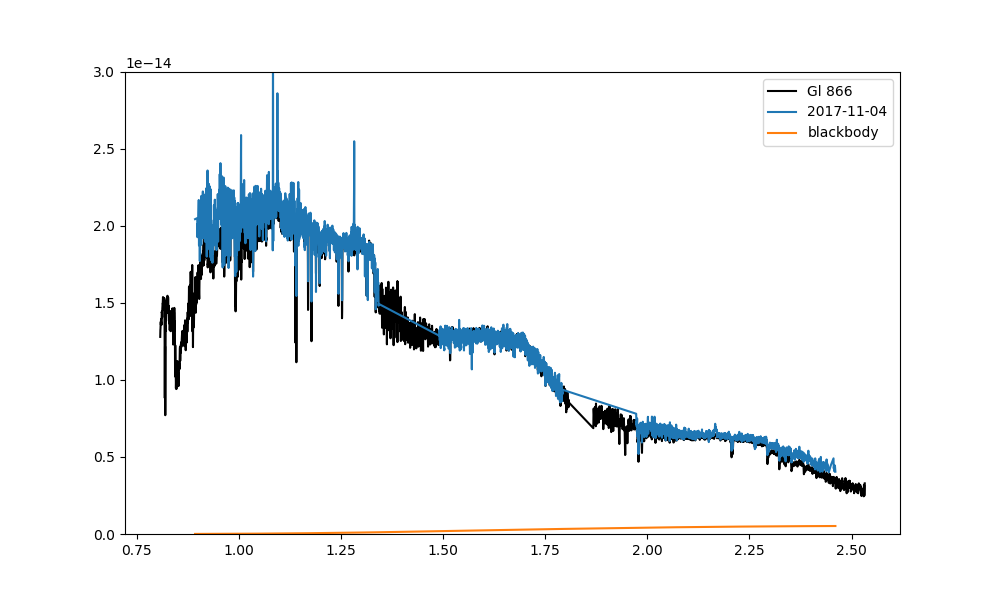

<IPython.core.display.Javascript object>


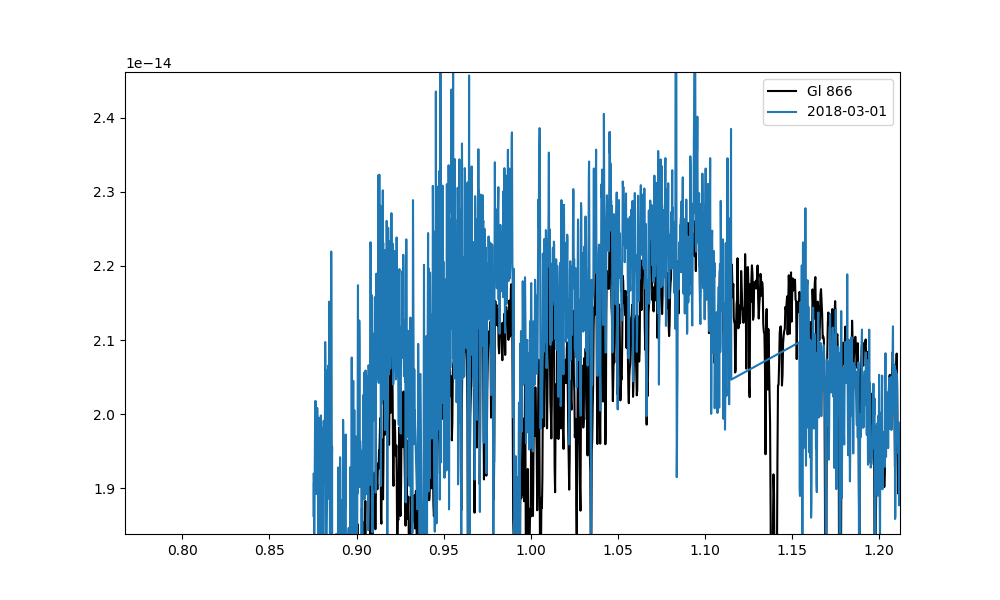

<IPython.core.display.Javascript object>


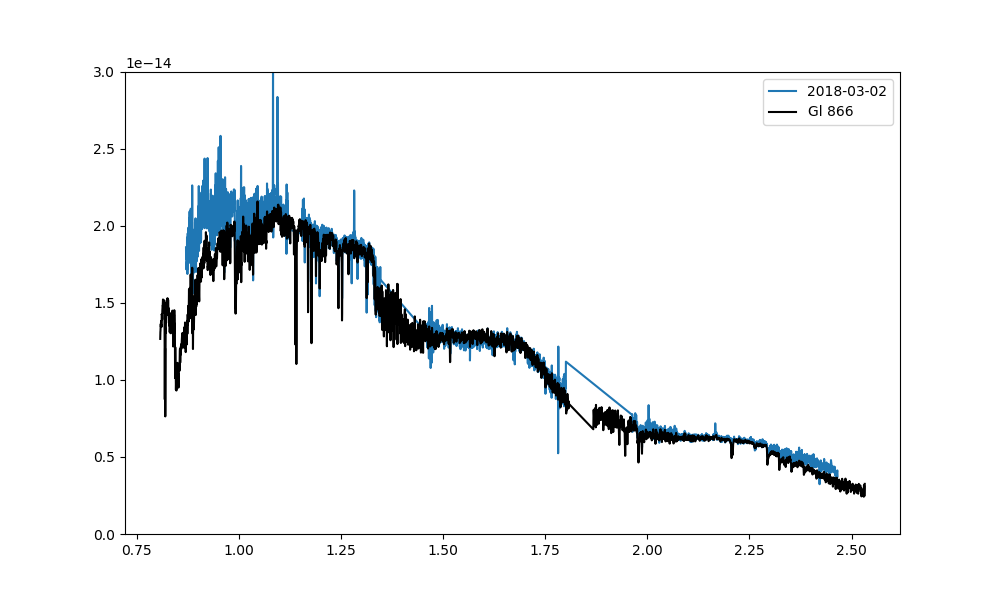

In [71]:
plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts,label='2017-11-04')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody')
#plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts - awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody subtracted')
plt.ylim([0.,3.0e-14])
#plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.0026,'k',label='Gl 866')
plt.plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts,label='2018-03-01')
#plt.plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_blackbody, label='blackbody')
#plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts - awi0005x3s_20180301_blackbody, label='blackbody subtracted')
plt.ylim([0.,3.0e-14])
#plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10.,6.))
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts,label='2018-03-02')
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.002425,'k',label='Gl 866')
#plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_blackbody, label='blackbody')
#plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts - awi0005x3s_20180302_blackbody, label='blackbody subtracted')
plt.ylim([0.,3.0e-14])
#plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(template_spectrum.short_wavelength, template_blackbody)
#plt.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density/399.) + template_blackbody)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_remerged_blackbody_trunclong_plotting)
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts - awi0005x3s_20171104_remerged_blackbody_trunclong_plotting)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(template_spectrum.short_wavelength, template_blackbody_trunclong_plotting)
#plt.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density/399.) + template_blackbody_trunclong_plotting)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/399.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts,label='AWI0005x3s')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged_blackbody)
#plt.ylim([1.0e-16,1.0e-13])
#plt.yscale('log',nonposy='clip')
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/399.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts - awi0005x3s_20171104_remerged_blackbody, label='AWI0005x3s blackbody subtracted')
#plt.ylim([0.,6.0e-14])
#plt.show()

<IPython.core.display.Javascript object>


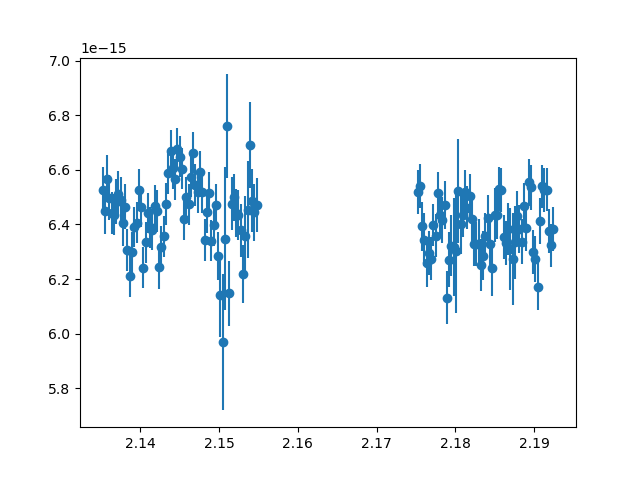

<IPython.core.display.Javascript object>


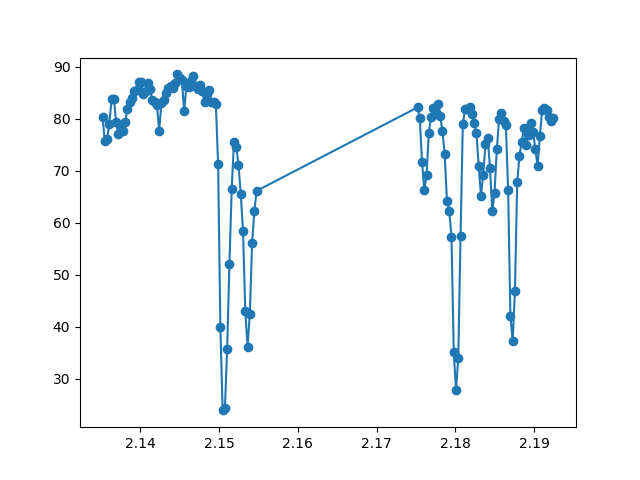

6.41709473139e-16
1.24510490132e-17
51.5385870266

6.42841528532e-16
1.2502406606e-17
51.4174229641
Right
6.38617536381e-16
9.84839779014e-18
64.8448153689
Left
6.44442924476e-16
1.37990536808e-17
46.7019651768


In [11]:
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x = np.array([x for x in awi0005x3s_20171104_2mass_highsnr_wav if ((x > 2.135 and x <2.155) or (x>2.175 and x<2.1925))])
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux = np.array([awi0005x3s_20171104_2mass_highsnr_flux_watts[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if ((awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.135 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.155) or (awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.175 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.1925))])
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err = np.array([awi0005x3s_20171104_2mass_highsnr_err[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if ((awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.135 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.155) or (awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.175 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.1925))])

plt.figure()
plt.errorbar(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux,yerr=awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err,fmt='o')
plt.show()

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux/awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err,'o-')
plt.show()

awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux.size)/10.
print awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_avg

difs = (awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux/10.) - awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_avg
difs_square = difs**2
avg_difs_square = np.sum(difs_square)/float(difs_square.size)
rms = avg_difs_square**0.5
print rms

snr = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_avg/rms
print snr


print ''
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_errweight_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux/10.*(1./((awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err/10.)**2)))/np.sum((1./((awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err/10.)**2)))
print awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_errweight_avg

difs_errweight = (awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux/10.) - awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_errweight_avg
difs_errweight_square = difs_errweight**2
avg_difs_errweight_square = np.sum(difs_errweight_square)/float(difs_errweight_square.size)
rms_errweight = avg_difs_errweight_square**0.5
print rms_errweight

snr_errweight = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_errweight_avg/rms_errweight
print snr_errweight


print 'Right'
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right = np.array([awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux[i] for i in range(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x.size) if (awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x[i] > 2.16)])/10.
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right.size)
print awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right_avg

difs_right = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right - awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right_avg
difs_square_right = difs_right**2
avg_difs_square_right = np.sum(difs_square_right)/float(difs_square_right.size)
rms_right = avg_difs_square_right**0.5
print rms_right

snr_right = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right_avg/rms_right
print snr_right


print 'Left'
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left = np.array([awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux[i] for i in range(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x.size) if (awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x[i] <2.16)])/10.
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left.size)
print awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left_avg

difs_left = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left - awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left_avg
difs_square_left = difs_left**2
avg_difs_square_left = np.sum(difs_square_left)/float(difs_square_left.size)
rms_left = avg_difs_square_left**0.5
print rms_left

snr_left = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left_avg/rms_left
print snr_left

In [12]:
def get_highsnr_continuum(continuum_spec, highsnr_wav):
    continuum_wav = continuum_spec.wavelength
    continuum_flux = continuum_spec.flux_density
    
    continuum_highsnr_wav = [x for x in continuum_wav if x in highsnr_wav]
    continuum_highsnr_flux = [continuum_flux[i] for i in range(continuum_wav.size) if (continuum_wav[i] in highsnr_wav)]
    
    return continuum_highsnr_wav, continuum_highsnr_flux

First row found: 34


<IPython.core.display.Javascript object>


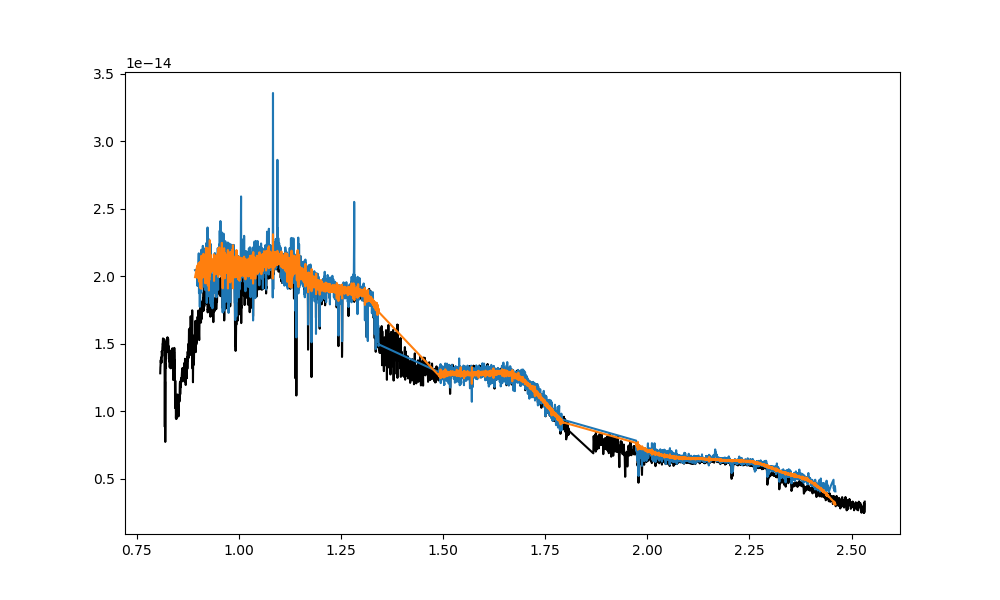

In [74]:
awi0005x3s_xtc_20171104_2massweighted_normalized = import_continuum_spectrum_from_file('awi0005x3s_xtc_20171104_2massweighted_merged_IRAF_con.txt',True)

#awi0005x3s_xtc_20171104_2massweighted_normalized_wav_use = np.array([x for x in awi0005x3s_xtc_20171104_2massweighted_normalized.wavelength if x in awi0005x3s_20171104_2massweighted_merged.wav])
awi0005x3s_xtc_20171104_2massweighted_normalized_flux_use = np.interp(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_xtc_20171104_2massweighted_normalized.wavelength, awi0005x3s_xtc_20171104_2massweighted_normalized.flux_density)

#print awi0005x3s_xtc_20171104_2massweighted_normalized.wavelength.size
#print awi0005x3s_20171104_2massweighted_merged.wav.size

awi0005x3s_xtc_20171104_2massweighted_continuum_flux = awi0005x3s_20171104_2mass_highsnr_flux_watts / awi0005x3s_xtc_20171104_2massweighted_normalized_flux_use

#print awi0005x3s_xtc_20171104_2massweighted_normalized_flux_use.size
#print awi0005x3s_xtc_20171104_2massweighted_normalized_wav_use.size
#awi0005x3s_xtc_20171104_2massweighted_highsnr_wav, awi0005x3s_xtc_20171104_2massweighted_continuum_highsnr_flux = get_highsnr_continuum(awi0005x3s_xtc_20171104_2massweighted_continuum, awi0005x3s_20171104_2mass_highsnr_wav)

plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts,label='2017-11-04')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav,awi0005x3s_xtc_20171104_2massweighted_continuum_flux,label='IRAF Cont.')
plt.show()

In [14]:
awi0005x3s_continuum_vals_brgamma_cont = np.interp(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x,awi0005x3s_20171104_2mass_highsnr_wav,awi0005x3s_xtc_20171104_2massweighted_continuum_flux)

difs_continuum = awi0005x3s_continuum_vals_brgamma_cont - awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux

difs_continuum_square = difs_continuum**2

avg_difs_continuum_square_errweight = np.sum(difs_continuum_square*(1/(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err**2)))/np.sum(1/(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err**2))

rms_continuum_errweight = avg_difs_continuum_square_errweight ** 0.5

snr_continuum_errweight = (np.sum(awi0005x3s_continuum_vals_brgamma_cont)/float(awi0005x3s_continuum_vals_brgamma_cont.size))/rms_continuum_errweight

print np.sum(awi0005x3s_continuum_vals_brgamma_cont)/float(awi0005x3s_continuum_vals_brgamma_cont.size)
print rms_continuum_errweight
print snr_continuum_errweight

6.40460613516e-15
1.01613542692e-16
63.029060551


<IPython.core.display.Javascript object>


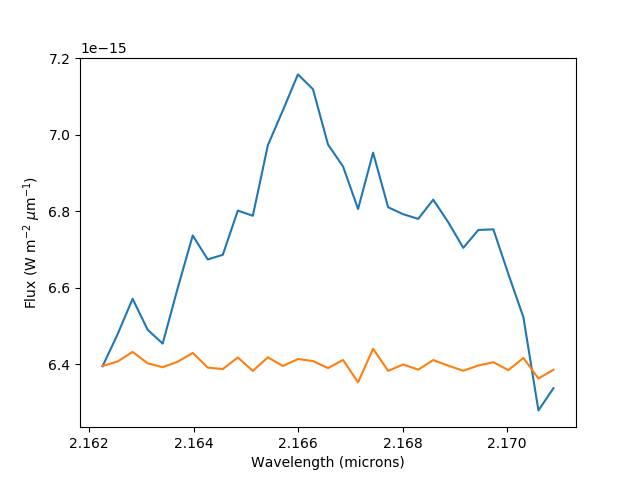

eq width (angstroms): -4.6076109427
log(eq width (angstroms)): 0.66347580102
pixels 31
wavespace: 86.3289834
h_lambda: 2.78480591613
f*/fc 1.05152696813
unc. eq width (angstroms): 0.252258119271
fractional uncertainty: 0.0547481378979
continuum level: 6.39941096757e-15 1.01531117735e-16
fractional uncertainty: 0.0158656973665
line flux (W/m2): 2.9485996001e-18 1.68072219388e-19
line flux (erg/s/cm2): 2.9485996001e-15 1.68072219388e-16
-14.5303841977


In [15]:
awi0005x3s_20171104_2mass_highsnr_brgamma_linewav = np.array([x for x in awi0005x3s_20171104_2mass_highsnr_wav if ((x > 2.162) and (x<2.171))])
awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux = np.array([awi0005x3s_20171104_2mass_highsnr_flux_watts[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if (awi0005x3s_20171104_2mass_highsnr_wav[i] in awi0005x3s_20171104_2mass_highsnr_brgamma_linewav)])
awi0005x3s_20171104_2mass_highsnr_brgamma_linecont = np.array([awi0005x3s_xtc_20171104_2massweighted_continuum_flux[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if (awi0005x3s_20171104_2mass_highsnr_wav[i] in awi0005x3s_20171104_2mass_highsnr_brgamma_linewav)])

awi0005x3s_20171104_2mass_highsnr_brgamma_linewav_angstroms = awi0005x3s_20171104_2mass_highsnr_brgamma_linewav * 10000.

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_linewav, awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux)
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_linewav, awi0005x3s_20171104_2mass_highsnr_brgamma_linecont)
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Flux (W m$^{-2}$ $\mu$m$^{-1}$)')
plt.show()

awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio = awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux/awi0005x3s_20171104_2mass_highsnr_brgamma_linecont

awi0005x3s_20171104_brgamma_eqwidth_angstroms = np.trapz((1.-awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio),x=awi0005x3s_20171104_2mass_highsnr_brgamma_linewav_angstroms)
#awi0005x3s_20171104_brgamma_eqwidth_angstroms = awi0005x3s_20171104_brgamma_eqwidth*10000.

print "eq width (angstroms):", awi0005x3s_20171104_brgamma_eqwidth_angstroms
print "log(eq width (angstroms)):",np.log10(-awi0005x3s_20171104_brgamma_eqwidth_angstroms)
print "pixels",awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size
print "wavespace:",awi0005x3s_20171104_2mass_highsnr_brgamma_linewav_angstroms[-1] - awi0005x3s_20171104_2mass_highsnr_brgamma_linewav_angstroms[0]
print "h_lambda:",(awi0005x3s_20171104_2mass_highsnr_brgamma_linewav_angstroms[-1] - awi0005x3s_20171104_2mass_highsnr_brgamma_linewav_angstroms[0])/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size)

hlambda = (awi0005x3s_20171104_2mass_highsnr_brgamma_linewav_angstroms[-1] - awi0005x3s_20171104_2mass_highsnr_brgamma_linewav_angstroms[0])/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size)

fstar_fc = np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size)
print 'f*/fc',fstar_fc
#print np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size), np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size)
#print (np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size))/(np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size))

awi0005x3s_20171104_brgamma_eqwidth_unc_angstroms = np.sqrt(float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size)*((hlambda/snr_continuum_errweight)**2)*fstar_fc)
#awi0005x3s_20171104_brgamma_eqwidth_unc_angstroms = awi0005x3s_20171104_brgamma_eqwidth_unc*10000.

print "unc. eq width (angstroms):",awi0005x3s_20171104_brgamma_eqwidth_unc_angstroms
print "fractional uncertainty:",awi0005x3s_20171104_brgamma_eqwidth_unc_angstroms/abs(awi0005x3s_20171104_brgamma_eqwidth_angstroms)

awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg = np.trapz(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont,x=awi0005x3s_20171104_2mass_highsnr_brgamma_linewav)/(awi0005x3s_20171104_2mass_highsnr_brgamma_linewav[-1]-awi0005x3s_20171104_2mass_highsnr_brgamma_linewav[0])
awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg_unc = awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg/snr_continuum_errweight

print "continuum level:",awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg, awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg_unc
print "fractional uncertainty:",awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg_unc/awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg


awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux = awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg * awi0005x3s_20171104_brgamma_eqwidth_angstroms/10000.*-1.
awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux_unc = ((((awi0005x3s_20171104_brgamma_eqwidth_unc_angstroms/abs(awi0005x3s_20171104_brgamma_eqwidth_angstroms))**2) + ((awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg_unc/awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg)**2))**0.5)*awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux
print 'line flux (W/m2):',awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux, awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux_unc

awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux_cgs = awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux * 1000. 
awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux_unc_cgs = awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux_unc * 1000.
print 'line flux (erg/s/cm2):',awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux_cgs, awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux_unc_cgs

print np.log10(awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux_cgs)

#awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity = 

<IPython.core.display.Javascript object>


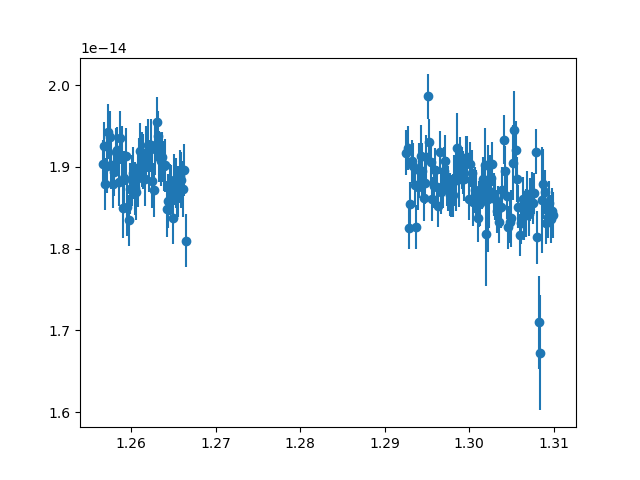

<IPython.core.display.Javascript object>


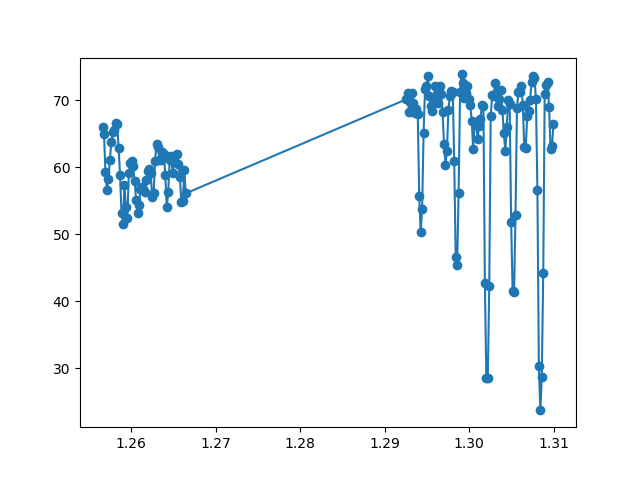

1.87895162527e-14
3.78667533078e-16
49.620087838

1.87906942458e-14
3.78669365377e-16
49.6229586121


In [34]:
awi0005x3s_20171104_2mass_highsnr_pabeta_cont_x = np.array([x for x in awi0005x3s_20171104_2mass_highsnr.wav if ((x > 1.2565 and x <1.2665) or (x>1.2925 and x<1.31))])
awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux = np.array([awi0005x3s_20171104_2mass_highsnr.flux_watts[i] for i in range(awi0005x3s_20171104_2mass_highsnr.wav.size) if ((awi0005x3s_20171104_2mass_highsnr.wav[i]>1.2565 and awi0005x3s_20171104_2mass_highsnr.wav[i]<1.2665) or (awi0005x3s_20171104_2mass_highsnr.wav[i]>1.2925 and awi0005x3s_20171104_2mass_highsnr.wav[i]<1.31))])
awi0005x3s_20171104_2mass_highsnr_pabeta_cont_err = np.array([awi0005x3s_20171104_2mass_highsnr.err_watts[i] for i in range(awi0005x3s_20171104_2mass_highsnr.wav.size) if ((awi0005x3s_20171104_2mass_highsnr.wav[i]>1.2565 and awi0005x3s_20171104_2mass_highsnr.wav[i]<1.2665) or (awi0005x3s_20171104_2mass_highsnr.wav[i]>1.2925 and awi0005x3s_20171104_2mass_highsnr.wav[i]<1.31))])

plt.figure()
plt.errorbar(awi0005x3s_20171104_2mass_highsnr_pabeta_cont_x, awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux,yerr=awi0005x3s_20171104_2mass_highsnr_pabeta_cont_err,fmt='o')
plt.show()

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_pabeta_cont_x, awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux/awi0005x3s_20171104_2mass_highsnr_pabeta_cont_err,'o-')
plt.show()

awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux)/float(awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux.size)
print awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux_avg

difs_pabeta = (awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux) - awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux_avg
difs_square_pabeta = difs_pabeta**2
avg_difs_square_pabeta = np.sum(difs_square_pabeta)/float(difs_square_pabeta.size)
rms_pabeta = avg_difs_square_pabeta**0.5
print rms_pabeta

snr_pabeta = awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux_avg/rms_pabeta
print snr_pabeta


print ''
awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux_errweight_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux*(1./((awi0005x3s_20171104_2mass_highsnr_pabeta_cont_err)**2)))/np.sum((1./((awi0005x3s_20171104_2mass_highsnr_pabeta_cont_err)**2)))
print awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux_errweight_avg

difs_pabeta_errweight = (awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux) - awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux_errweight_avg
difs_pabeta_errweight_square = difs_pabeta_errweight**2
avg_difs_pabeta_errweight_square = np.sum(difs_pabeta_errweight_square)/float(difs_pabeta_errweight_square.size)
rms_pabeta_errweight = avg_difs_pabeta_errweight_square**0.5
print rms_pabeta_errweight

snr_pabeta_errweight = awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux_errweight_avg/rms_pabeta_errweight
print snr_pabeta_errweight

In [17]:
awi0005x3s_continuum_vals_pabeta_cont = np.interp(awi0005x3s_20171104_2mass_highsnr_pabeta_cont_x,awi0005x3s_20171104_2mass_highsnr_wav,awi0005x3s_xtc_20171104_2massweighted_continuum_flux)

difs_continuum_pabeta = awi0005x3s_continuum_vals_pabeta_cont - awi0005x3s_20171104_2mass_highsnr_pabeta_cont_flux

difs_continuum_square_pabeta = difs_continuum_pabeta**2

avg_difs_continuum_square_errweight_pabeta = np.sum(difs_continuum_square_pabeta*(1/(awi0005x3s_20171104_2mass_highsnr_pabeta_cont_err**2)))/np.sum(1/(awi0005x3s_20171104_2mass_highsnr_pabeta_cont_err**2))

rms_continuum_errweight_pabeta = avg_difs_continuum_square_errweight_pabeta ** 0.5

snr_continuum_errweight_pabeta = (np.sum(awi0005x3s_continuum_vals_pabeta_cont)/float(awi0005x3s_continuum_vals_pabeta_cont.size))/rms_continuum_errweight_pabeta

print np.sum(awi0005x3s_continuum_vals_pabeta_cont)/float(awi0005x3s_continuum_vals_pabeta_cont.size)
print rms_continuum_errweight_pabeta
print snr_continuum_errweight_pabeta

1.88078583484e-14
2.29926351697e-16
81.7994901828


<IPython.core.display.Javascript object>


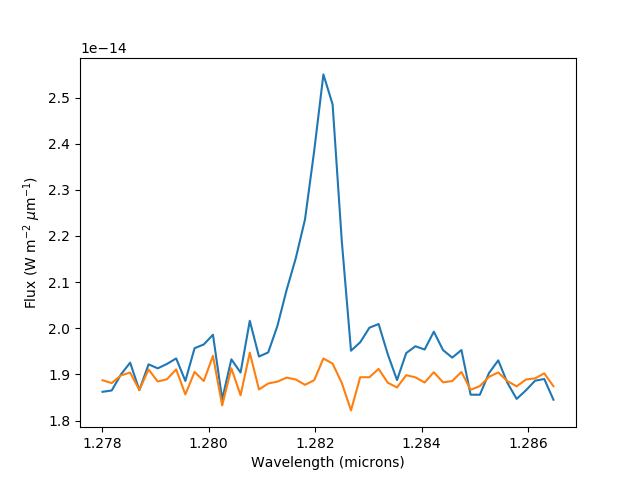

eq width (angstroms): -3.95832861791
log(eq width (angstroms)): 0.597511846218
pixels 50
wavespace: 84.6540928
h_lambda: 2.7307771871
f*/fc 1.04553503673
unc. eq width (angstroms): 0.241373710596
fractional uncertainty: 0.0609786942659
continuum level: 1.88959510218e-14 2.31003285956e-16
fractional uncertainty: 0.0122250150675
line flux (W/m2): 7.47963836922e-18 1.85788018e-19
line flux (erg/s/cm2): 7.47963836922e-15 1.85788018e-16
-14.1261193992


In [18]:
awi0005x3s_20171104_2mass_highsnr_pabeta_linewav = np.array([x for x in awi0005x3s_20171104_2mass_highsnr.wav if ((x > 1.278) and (x<1.2865))])
awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux = np.array([awi0005x3s_20171104_2mass_highsnr.flux_watts[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if (awi0005x3s_20171104_2mass_highsnr_wav[i] in awi0005x3s_20171104_2mass_highsnr_pabeta_linewav)])
awi0005x3s_20171104_2mass_highsnr_pabeta_linecont = np.array([awi0005x3s_xtc_20171104_2massweighted_continuum_flux[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if (awi0005x3s_20171104_2mass_highsnr_wav[i] in awi0005x3s_20171104_2mass_highsnr_pabeta_linewav)])

awi0005x3s_20171104_2mass_highsnr_pabeta_linewav_angstroms = awi0005x3s_20171104_2mass_highsnr_pabeta_linewav * 10000.

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_pabeta_linewav, awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux)
plt.plot(awi0005x3s_20171104_2mass_highsnr_pabeta_linewav, awi0005x3s_20171104_2mass_highsnr_pabeta_linecont)
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Flux (W m$^{-2}$ $\mu$m$^{-1}$)')
plt.show()

awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_ratio = awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux/awi0005x3s_20171104_2mass_highsnr_pabeta_linecont

awi0005x3s_20171104_pabeta_eqwidth_angstroms = np.trapz((1.-awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_ratio),x=awi0005x3s_20171104_2mass_highsnr_pabeta_linewav_angstroms)
#awi0005x3s_20171104_brgamma_eqwidth_angstroms = awi0005x3s_20171104_brgamma_eqwidth*10000.

print "eq width (angstroms):", awi0005x3s_20171104_pabeta_eqwidth_angstroms
print "log(eq width (angstroms)):",np.log10(-awi0005x3s_20171104_pabeta_eqwidth_angstroms)
print "pixels",awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_ratio.size
print "wavespace:",awi0005x3s_20171104_2mass_highsnr_pabeta_linewav_angstroms[-1] - awi0005x3s_20171104_2mass_highsnr_pabeta_linewav_angstroms[0]
print "h_lambda:",(awi0005x3s_20171104_2mass_highsnr_pabeta_linewav_angstroms[-1] - awi0005x3s_20171104_2mass_highsnr_pabeta_linewav_angstroms[0])/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size)

hlambda_pabeta = (awi0005x3s_20171104_2mass_highsnr_pabeta_linewav_angstroms[-1] - awi0005x3s_20171104_2mass_highsnr_pabeta_linewav_angstroms[0])/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size)

fstar_fc_pabeta = np.sum(awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_ratio)/float(awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_ratio.size)
print 'f*/fc',fstar_fc_pabeta
#print np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size), np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size)
#print (np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size))/(np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_ratio.size))

awi0005x3s_20171104_pabeta_eqwidth_unc_angstroms = np.sqrt(float(awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_ratio.size)*((hlambda_pabeta/snr_continuum_errweight_pabeta)**2)*fstar_fc_pabeta)
#awi0005x3s_20171104_brgamma_eqwidth_unc_angstroms = awi0005x3s_20171104_brgamma_eqwidth_unc*10000.

print "unc. eq width (angstroms):",awi0005x3s_20171104_pabeta_eqwidth_unc_angstroms
print "fractional uncertainty:",awi0005x3s_20171104_pabeta_eqwidth_unc_angstroms/abs(awi0005x3s_20171104_pabeta_eqwidth_angstroms)

awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_avg = np.trapz(awi0005x3s_20171104_2mass_highsnr_pabeta_linecont,x=awi0005x3s_20171104_2mass_highsnr_pabeta_linewav)/(awi0005x3s_20171104_2mass_highsnr_pabeta_linewav[-1]-awi0005x3s_20171104_2mass_highsnr_pabeta_linewav[0])
awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_avg_unc = awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_avg/snr_continuum_errweight_pabeta

print "continuum level:",awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_avg, awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_avg_unc
print "fractional uncertainty:",awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_avg_unc/awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_avg


awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux = awi0005x3s_20171104_2mass_highsnr_pabeta_linecont_avg * awi0005x3s_20171104_pabeta_eqwidth_angstroms/10000.*-1.
awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux_unc = ((((awi0005x3s_20171104_pabeta_eqwidth_unc_angstroms/abs(awi0005x3s_20171104_pabeta_eqwidth_angstroms))**2) + ((awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg_unc/awi0005x3s_20171104_2mass_highsnr_brgamma_linecont_avg)**2))**0.5)*awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux
print 'line flux (W/m2):',awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux, awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux_unc

awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux_cgs = awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux * 1000. 
awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux_unc_cgs = awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux_unc * 1000.
print 'line flux (erg/s/cm2):',awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux_cgs, awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux_unc_cgs

print np.log10(awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux_cgs)


In [19]:
parallax = 9.8599
parallax_error = 0.0551

distance_pc = 1000./parallax
distance_error_pc = (parallax_error/parallax)*distance_pc

distance = distance_pc * 3.08567758149137e16
distance_error = distance_error_pc * 3.08567758149137e16


awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity = awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux * 4. * np.pi * (distance**2)
awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity_unc = 4.*np.pi*distance * ((4*(awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux**2)*(distance_error**2) +((distance**2)*(awi0005x3s_20171104_2mass_highsnr_brgamma_lineflux_unc**2)))**0.5)

print awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity, awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity_unc

Lsol_nom = 3.828e26

print awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity/Lsol_nom, awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity_unc/Lsol_nom

print np.log10(awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity/Lsol_nom), np.log(10.)*(awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity_unc/awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity)

awi0005x3s_20171104_2mass_highsnr_logBrGamma = np.log10(awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity/Lsol_nom)
awi0005x3s_20171104_2mass_highsnr_logBrGamma_unc = np.log(10.)*(awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity_unc/awi0005x3s_20171104_2mass_highsnr_brgamma_luminosity)

awi0005x3s_20171104_2mass_highsnr_logLacc_brgamma = (1.26*awi0005x3s_20171104_2mass_highsnr_logBrGamma) + 4.43

awi0005x3s_20171104_2mass_highsnr_logLacc_brgamma_unc = (((awi0005x3s_20171104_2mass_highsnr_logBrGamma**2) * (0.19**2)) + ((1.14**2)*(awi0005x3s_20171104_2mass_highsnr_logBrGamma_unc**2)) + (0.79**2))**0.5

print awi0005x3s_20171104_2mass_highsnr_logLacc_brgamma, awi0005x3s_20171104_2mass_highsnr_logLacc_brgamma_unc

3.6289562808e+20 2.10791916535e+19
9.4800320815e-07 5.50658089171e-08
-6.02319019296 0.133748187407
-3.15921964313 1.3989329509


In [20]:
awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity = awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux * 4. * np.pi * (distance**2)
awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity_unc = 4.*np.pi*distance * ((4*(awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux**2)*(distance_error**2) +((distance**2)*(awi0005x3s_20171104_2mass_highsnr_pabeta_lineflux_unc**2)))**0.5)

print awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity, awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity_unc

Lsol_nom = 3.828e26

print awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity/Lsol_nom, awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity_unc/Lsol_nom

print np.log10(awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity/Lsol_nom), np.log(10.)*(awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity_unc/awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity)

awi0005x3s_20171104_2mass_highsnr_logPaBeta = np.log10(awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity/Lsol_nom)
awi0005x3s_20171104_2mass_highsnr_logPaBeta_unc = np.log(10.)*(awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity_unc/awi0005x3s_20171104_2mass_highsnr_pabeta_luminosity)

awi0005x3s_20171104_2mass_highsnr_logLacc_pabeta = 1.14*awi0005x3s_20171104_2mass_highsnr_logPaBeta + 3.15
awi0005x3s_20171104_2mass_highsnr_logLacc_pabeta_unc = (((awi0005x3s_20171104_2mass_highsnr_logPaBeta**2)*(0.16**2)) + ((1.14**2)*(awi0005x3s_20171104_2mass_highsnr_logPaBeta_unc**2)) + (0.58*0.58))**0.5

print awi0005x3s_20171104_2mass_highsnr_logLacc_pabeta, awi0005x3s_20171104_2mass_highsnr_logLacc_pabeta_unc

9.20548203193e+20 2.50737535737e+19
2.40477587041e-06 6.55009236512e-08
-5.61892539446 0.0627174666182
-3.25557494968 1.072270213


In [47]:
def get_pabeta_luminosity(target_spectrum, distance, distance_unc):
    pabeta_luminosity_watts = target_spectrum.pabeta_lineflux * 4. * np.pi * (distance**2)
    pabeta_luminosity_unc_watts = 4. * np.pi * distance * ((((4.*(target_spectrum.pabeta_lineflux**2))*(distance_unc**2)) + ((distance**2)*(target_spectrum.pabeta_lineflux_unc**2)))**0.5)
    
    pabeta_luminosity_Lsol = pabeta_luminosity_watts / (3.828e26)
    pabeta_luminosity_unc_Lsol = pabeta_luminosity_unc_watts / (3.828e26)
    
    log_pabeta_luminosity_Lsol = np.log10(pabeta_luminosity_Lsol)
    log_pabeta_luminosity_unc_Lsol = (1/np.log(10.))*(pabeta_luminosity_unc_Lsol/pabeta_luminosity_Lsol)
    
    print log_pabeta_luminosity_Lsol, log_pabeta_luminosity_unc_Lsol
    
    return pabeta_luminosity_Lsol, pabeta_luminosity_unc_Lsol, log_pabeta_luminosity_Lsol, log_pabeta_luminosity_unc_Lsol


def get_brgamma_luminosity(target_spectrum, distance, distance_unc):
    brgamma_luminosity_watts = target_spectrum.brgamma_lineflux * 4. * np.pi * (distance**2)
    brgamma_luminosity_unc_watts = 4. * np.pi * distance * ((((4.*(target_spectrum.brgamma_lineflux**2))*(distance_unc**2)) + ((distance**2)*(target_spectrum.brgamma_lineflux_unc**2)))**0.5)
    
    brgamma_luminosity_Lsol = brgamma_luminosity_watts / (3.828e26)
    brgamma_luminosity_unc_Lsol = brgamma_luminosity_unc_watts / (3.828e26)
    
    log_brgamma_luminosity_Lsol = np.log10(brgamma_luminosity_Lsol)
    log_brgamma_luminosity_unc_Lsol = (1/np.log(10.))*(brgamma_luminosity_unc_Lsol/brgamma_luminosity_Lsol)
    
    print log_brgamma_luminosity_Lsol, log_brgamma_luminosity_unc_Lsol
    
    return brgamma_luminosity_Lsol, brgamma_luminosity_unc_Lsol, log_brgamma_luminosity_Lsol, log_brgamma_luminosity_unc_Lsol

In [43]:
def get_Pabeta_flux(target_spectrum, continuum_flux_use):
    print r'Pa $\beta$'
    pabeta_cont_x = np.array([x for x in target_spectrum.wav if ((x > 1.2565 and x <1.2665) or (x>1.2925 and x<1.31))])
    pabeta_cont_flux = np.array([target_spectrum.flux_watts[i] for i in range(target_spectrum.wav.size) if ((target_spectrum.wav[i]>1.2565 and target_spectrum.wav[i]<1.2665) or (target_spectrum.wav[i]>1.2925 and target_spectrum.wav[i]<1.31))])
    pabeta_cont_err = np.array([target_spectrum.err_watts[i] for i in range(target_spectrum.wav.size) if ((target_spectrum.wav[i]>1.2565 and target_spectrum.wav[i]<1.2665) or (target_spectrum.wav[i]>1.2925 and target_spectrum.wav[i]<1.31))])
    pabeta_continuum_vals_cont = np.interp(pabeta_cont_x,target_spectrum.wav,continuum_flux_use)
    
    difs_continuum_pabeta = pabeta_continuum_vals_cont - pabeta_cont_flux
    difs_continuum_square_pabeta = difs_continuum_pabeta**2
    avg_difs_continuum_square_errweight_pabeta = np.sum(difs_continuum_square_pabeta*(1/(pabeta_cont_err**2)))/np.sum(1/(pabeta_cont_err**2))
    rms_continuum_errweight_pabeta = avg_difs_continuum_square_errweight_pabeta ** 0.5
    snr_continuum_errweight_pabeta = (np.sum(pabeta_continuum_vals_cont)/float(pabeta_continuum_vals_cont.size))/rms_continuum_errweight_pabeta

    print np.sum(pabeta_continuum_vals_cont)/float(pabeta_continuum_vals_cont.size)
    print rms_continuum_errweight_pabeta
    print snr_continuum_errweight_pabeta
    
    
    pabeta_linewav = np.array([x for x in target_spectrum.wav if ((x > 1.278) and (x<1.2865))])
    pabeta_lineflux = np.array([target_spectrum.flux_watts[i] for i in range(target_spectrum.wav.size) if (target_spectrum.wav[i] in pabeta_linewav)])
    pabeta_linecont = np.array([continuum_flux_use[i] for i in range(target_spectrum.wav.size) if (target_spectrum.wav[i] in pabeta_linewav)])

    pabeta_linewav_angstroms = pabeta_linewav * 10000.
    
    
    pabeta_linecont_ratio = pabeta_lineflux/pabeta_linecont

    pabeta_eqwidth_angstroms = np.trapz((1.-pabeta_linecont_ratio),x=pabeta_linewav_angstroms)
    #awi0005x3s_20171104_brgamma_eqwidth_angstroms = awi0005x3s_20171104_brgamma_eqwidth*10000.

    print "eq width (angstroms):", pabeta_eqwidth_angstroms
    print "log(eq width (angstroms)):",np.log10(-pabeta_eqwidth_angstroms)
    print "pixels",pabeta_linecont_ratio.size
    print "wavespace:",pabeta_linewav_angstroms[-1] - pabeta_linewav_angstroms[0]
    print "h_lambda:",(pabeta_linewav_angstroms[-1] - pabeta_linewav_angstroms[0])/float(pabeta_linecont_ratio.size)

    hlambda_pabeta = (pabeta_linewav_angstroms[-1] - pabeta_linewav_angstroms[0])/float(pabeta_linecont_ratio.size)

    fstar_fc_pabeta = np.sum(pabeta_linecont_ratio)/float(pabeta_linecont_ratio.size)
    print 'f*/fc',fstar_fc_pabeta

    pabeta_eqwidth_unc_angstroms = np.sqrt(float(pabeta_linecont_ratio.size)*((hlambda_pabeta/snr_continuum_errweight_pabeta)**2)*fstar_fc_pabeta)

    print "unc. eq width (angstroms):",pabeta_eqwidth_unc_angstroms
    print "fractional uncertainty:",pabeta_eqwidth_unc_angstroms/abs(pabeta_eqwidth_angstroms)

    pabeta_linecont_avg = np.trapz(pabeta_linecont,x=pabeta_linewav)/(pabeta_linewav[-1]-pabeta_linewav[0])
    pabeta_linecont_avg_unc = pabeta_linecont_avg/snr_continuum_errweight_pabeta

    print "continuum level:",pabeta_linecont_avg, pabeta_linecont_avg_unc
    print "fractional uncertainty:",pabeta_linecont_avg_unc/pabeta_linecont_avg


    pabeta_lineflux = pabeta_linecont_avg * pabeta_eqwidth_angstroms/10000.*-1.
    pabeta_lineflux_unc = ((((pabeta_eqwidth_unc_angstroms/abs(pabeta_eqwidth_angstroms))**2) + ((pabeta_linecont_avg_unc/pabeta_linecont_avg)**2))**0.5)*pabeta_lineflux
    print 'line flux (W/m2):',pabeta_lineflux, pabeta_lineflux_unc

    pabeta_lineflux_cgs = pabeta_lineflux * 1000. 
    pabeta_lineflux_unc_cgs = pabeta_lineflux_unc * 1000.
    print 'line flux (erg/s/cm2):',pabeta_lineflux_cgs, pabeta_lineflux_unc_cgs

    print np.log10(pabeta_lineflux_cgs)
    print ''

    return pabeta_eqwidth_angstroms, pabeta_eqwidth_unc_angstroms, pabeta_lineflux, pabeta_lineflux_unc

In [62]:
def get_Brgamma_flux(target_spectrum, continuum_flux_use):
    print r'Br $\gamma$'
    #Get observed continuum ranges and IRAF continuum values for determining SNR
    brgamma_cont_x = np.array([x for x in target_spectrum.wav if ((x > 2.135 and x <2.155) or (x>2.175 and x<2.1925))])
    brgamma_cont_flux = np.array([target_spectrum.flux_watts[i] for i in range(target_spectrum.wav.size) if ((target_spectrum.wav[i]>2.135 and target_spectrum.wav[i]<2.155) or (target_spectrum.wav[i]>2.175 and target_spectrum.wav[i]<2.1925))])
    brgamma_cont_err = np.array([target_spectrum.err_watts[i] for i in range(target_spectrum.wav.size) if ((target_spectrum.wav[i]>2.135 and target_spectrum.wav[i]<2.155) or (target_spectrum.wav[i]>2.175 and target_spectrum.wav[i]<2.1925))])
    brgamma_continuum_vals_cont = np.interp(brgamma_cont_x,target_spectrum.wav,continuum_flux_use)
    
    plt.figure()
    plt.errorbar(brgamma_cont_x, brgamma_cont_flux, yerr=brgamma_cont_err)
    plt.plot(brgamma_cont_x, brgamma_continuum_vals_cont)
    plt.show()
    
    #Calculate SNR
    difs_continuum_brgamma = brgamma_continuum_vals_cont - brgamma_cont_flux #Difference at each point between IRAF and observed
    difs_continuum_square_brgamma = difs_continuum_brgamma**2 #Squared difference
    avg_difs_continuum_square_errweight_brgamma = np.sum(difs_continuum_square_brgamma*(1/(brgamma_cont_err**2)))/np.sum(1/(brgamma_cont_err**2)) #Error-weighted average of squared differences
    rms_continuum_errweight_brgamma = avg_difs_continuum_square_errweight_brgamma ** 0.5 #RMS of error-weighted differences
    snr_continuum_errweight_brgamma = (np.sum(brgamma_continuum_vals_cont)/float(brgamma_continuum_vals_cont.size))/rms_continuum_errweight_brgamma #SNR--average continuum/error-weighted RMS

    print np.sum(brgamma_continuum_vals_cont)/float(brgamma_continuum_vals_cont.size) #Average continuum
    print rms_continuum_errweight_brgamma #RMS
    print snr_continuum_errweight_brgamma #SNR
    
    #Get in-line wavelength, flux, continuum
    brgamma_linewav = np.array([x for x in target_spectrum.wav if ((x > 2.162) and (x<2.171))])
    brgamma_lineflux = np.array([target_spectrum.flux_watts[i] for i in range(target_spectrum.wav.size) if (target_spectrum.wav[i] in brgamma_linewav)])
    brgamma_linecont = np.array([continuum_flux_use[i] for i in range(target_spectrum.wav.size) if (target_spectrum.wav[i] in brgamma_linewav)])

    brgamma_linewav_angstroms = brgamma_linewav * 10000. #In angstroms
    
    plt.figure()
    plt.plot(brgamma_linewav, brgamma_lineflux)
    plt.plot(brgamma_linewav, brgamma_linecont)
    plt.show()
    
    brgamma_linecont_ratio = brgamma_lineflux/brgamma_linecont #Line/continuum

    brgamma_eqwidth_angstroms = np.trapz((1.-brgamma_linecont_ratio),x=brgamma_linewav_angstroms) #Eq. width

    print "eq width (angstroms):", brgamma_eqwidth_angstroms
    print "log(eq width (angstroms)):",np.log10(-brgamma_eqwidth_angstroms)
    print "pixels",brgamma_linecont_ratio.size
    print "wavespace:",brgamma_linewav_angstroms[-1] - brgamma_linewav_angstroms[0]
    print "h_lambda:",(brgamma_linewav_angstroms[-1] - brgamma_linewav_angstroms[0])/float(brgamma_linecont_ratio.size)

    hlambda_brgamma = (brgamma_linewav_angstroms[-1] - brgamma_linewav_angstroms[0])/float(brgamma_linecont_ratio.size)

    fstar_fc_brgamma = np.sum(brgamma_linecont_ratio)/float(brgamma_linecont_ratio.size)
    print 'f*/fc',fstar_fc_brgamma

    brgamma_eqwidth_unc_angstroms = np.sqrt(float(brgamma_linecont_ratio.size)*((hlambda_brgamma/snr_continuum_errweight_brgamma)**2)*fstar_fc_brgamma)

    print "unc. eq width (angstroms):",brgamma_eqwidth_unc_angstroms
    print "fractional uncertainty:",brgamma_eqwidth_unc_angstroms/abs(brgamma_eqwidth_angstroms)

    brgamma_linecont_avg = np.trapz(brgamma_linecont,x=brgamma_linewav)/(brgamma_linewav[-1]-brgamma_linewav[0])
    brgamma_linecont_avg_unc = brgamma_linecont_avg/snr_continuum_errweight_brgamma

    print "continuum level:",brgamma_linecont_avg, brgamma_linecont_avg_unc
    print "fractional uncertainty:",brgamma_linecont_avg_unc/brgamma_linecont_avg


    brgamma_lineflux = brgamma_linecont_avg * brgamma_eqwidth_angstroms/10000.*-1.
    brgamma_lineflux_unc = ((((brgamma_eqwidth_unc_angstroms/abs(brgamma_eqwidth_angstroms))**2) + ((brgamma_linecont_avg_unc/brgamma_linecont_avg)**2))**0.5)*brgamma_lineflux
    print 'line flux (W/m2):',brgamma_lineflux, brgamma_lineflux_unc

    brgamma_lineflux_cgs = brgamma_lineflux * 1000. 
    brgamma_lineflux_unc_cgs = brgamma_lineflux_unc * 1000.
    print 'line flux (erg/s/cm2):',brgamma_lineflux_cgs, brgamma_lineflux_unc_cgs

    print np.log10(brgamma_lineflux_cgs)
    print ''

    return brgamma_eqwidth_angstroms, brgamma_eqwidth_unc_angstroms, brgamma_lineflux, brgamma_lineflux_unc

In [51]:
def get_accretion_luminosity_pabeta(target_spectrum):
    x = target_spectrum.log_pabeta_luminosity
    delx = target_spectrum.log_pabeta_luminosity_unc
    
    m = 1.14
    delm = 0.16
    
    b = 3.15
    delb = 0.58
    
    log_Lacc_Lsol = m*x + b
    
    log_Lacc_Lsol_unc = (((m**2)*(delx**2)) + ((x**2)*(delm**2)) + (delb**2))**0.5
    
    return log_Lacc_Lsol, log_Lacc_Lsol_unc

In [65]:
def get_accretion_luminosity_pabeta_test(target_spectrum):
    x = target_spectrum.log_pabeta_luminosity
    delx = target_spectrum.log_pabeta_luminosity_unc
    
    m = 1.36
    delm = 0.2
    
    b = 4.00
    delb = 0.2
    
    log_Lacc_Lsol = m*x + b
    
    log_Lacc_Lsol_unc = (((m**2)*(delx**2)) + ((x**2)*(delm**2)) + (delb**2))**0.5
    
    return log_Lacc_Lsol, log_Lacc_Lsol_unc

In [52]:
def get_accretion_luminosity_brgamma(target_spectrum):
    x = target_spectrum.log_brgamma_luminosity
    delx = target_spectrum.log_brgamma_luminosity_unc
    
    m = 1.26
    delm = 0.19
    
    b = 4.43
    delb = 0.79
    
    log_Lacc_Lsol = m*x + b
    
    log_Lacc_Lsol_unc = (((m**2)*(delx**2)) + ((x**2)*(delm**2)) + (delb**2))**0.5
    
    return log_Lacc_Lsol, log_Lacc_Lsol_unc

In [55]:
def get_final_accretion_luminosity(target_spectrum):
    a1 = target_spectrum.log_accretion_luminosity_pabeta
    da1 = target_spectrum.log_accretion_luminosity_pabeta_unc
    
    a2 = target_spectrum.log_accretion_luminosity_brgamma
    da2 = target_spectrum.log_accretion_luminosity_brgamma_unc
    
    weighted_average_num = (a1/(da1**2)) + (a2/(da2**2))
    weighted_average_den = (1./(da1**2)) + (1./(da2**2))
    
    weighted_average = weighted_average_num/weighted_average_den
    weighted_average_unc = weighted_average_den**0.5
    
    return weighted_average, weighted_average_unc

In [75]:
def get_accretion_luminosities(target_spectrum, continuum_spectrum, parallax, parallax_error):
    distance_parsec = 1000./parallax
    distance_unc_parsec = (parallax_error/parallax) * distance_parsec
    
    distance_meters = distance_parsec * 3.08567758149137e16
    distance_unc_meters = distance_unc_parsec * 3.08567758149137e16
    
    continuum_flux_interp = np.interp(target_spectrum.wav, continuum_spectrum.wavelength, continuum_spectrum.flux_density)
    if continuum_spectrum.is_normalized:
        continuum_flux_use = target_spectrum.flux_watts / continuum_flux_interp
    else:
        continuum_flux_use = continuum_flux_interp
    
    target_spectrum.pabeta_eqwidth_angstroms, target_spectrum.pabeta_eqwidth_unc_angstroms, target_spectrum.pabeta_lineflux, target_spectrum.pabeta_lineflux_unc =  get_Pabeta_flux(target_spectrum, continuum_flux_use)
    
    target_spectrum.brgamma_eqwidth_angstroms, target_spectrum.brgamma_eqwidth_unc_angstroms, target_spectrum.brgamma_lineflux, target_spectrum.brgamma_lineflux_unc =  get_Brgamma_flux(target_spectrum, continuum_flux_use)
    
    target_spectrum.pabeta_luminosity, target_spectrum.pabeta_luminosity_unc, target_spectrum.log_pabeta_luminosity, target_spectrum.log_pabeta_luminosity_unc = get_pabeta_luminosity(target_spectrum, distance_meters, distance_unc_meters)
    target_spectrum.brgamma_luminosity, target_spectrum.brgamma_luminosity_unc, target_spectrum.log_brgamma_luminosity, target_spectrum.log_brgamma_luminosity_unc = get_brgamma_luminosity(target_spectrum, distance_meters, distance_unc_meters)
    
    target_spectrum.log_accretion_luminosity_pabeta, target_spectrum.log_accretion_luminosity_pabeta_unc = get_accretion_luminosity_pabeta(target_spectrum)
    target_spectrum.log_accretion_luminosity_brgamma, target_spectrum.log_accretion_luminosity_brgamma_unc = get_accretion_luminosity_brgamma(target_spectrum)
    
    target_spectrum.log_accretion_luminosity, target_spectrum.log_accretion_luminosity_unc = get_final_accretion_luminosity(target_spectrum)
    
    #target_spectrum.log_accretion_luminosity = ((target_spectrum.log_accretion_luminosity_pabeta/(target_spectrum.log_accretion_luminosity_pabeta_unc**2)) + (target_spectrum.log_accretion_luminosity_brgamma/(target_spectrum.log_accretion_luminosity_brgamma_unc**2))/((1./(target_spectrum.log_accretion_luminosity_pabeta_unc**2)) + (1./(target_spectrum.log_accretion_luminosity_brgamma_unc**2))))
    #target_spectrum.log_accretion_luminosity_unc = ((1./(target_spectrum.log_accretion_luminosity_pabeta_unc**2)) + (1./(target_spectrum.log_accretion_luminosity_brgamma_unc**2)))**0.5
    
    print r'Pa $\beta$:'
    print 'Eq. Width:', target_spectrum.pabeta_eqwidth_angstroms, target_spectrum.pabeta_eqwidth_unc_angstroms
    print 'Line flux:', target_spectrum.pabeta_lineflux, target_spectrum.pabeta_lineflux_unc
    print r'log$_{10}$ L/Lsol:', target_spectrum.log_pabeta_luminosity, target_spectrum.log_pabeta_luminosity_unc
    print r'log$_{10}$ Lacc/Lsol:', target_spectrum.log_accretion_luminosity_pabeta, target_spectrum.log_accretion_luminosity_pabeta_unc
    print ''
    
    print r'Br $\gamma$:'
    print 'Eq. Width:', target_spectrum.brgamma_eqwidth_angstroms, target_spectrum.brgamma_eqwidth_unc_angstroms
    print 'Line flux:', target_spectrum.brgamma_lineflux, target_spectrum.brgamma_lineflux_unc
    print r'log$_{10}$ L/Lsol:', target_spectrum.log_brgamma_luminosity, target_spectrum.log_brgamma_luminosity_unc
    print r'log$_{10}$ Lacc/Lsol:', target_spectrum.log_accretion_luminosity_brgamma, target_spectrum.log_accretion_luminosity_brgamma_unc
    print ''
    
    print 'Accretion luminosity:', target_spectrum.log_accretion_luminosity, target_spectrum.log_accretion_luminosity_unc
    print ''
    
    test_pabeta_accretion_luminosity, test_pabeta_accretion_luminosity_unc = get_accretion_luminosity_pabeta_test(target_spectrum)
    print test_pabeta_accretion_luminosity, test_pabeta_accretion_luminosity_unc
    
    return

AWI0005x3s, 2017-11-04
Pa $\beta$
1.88078583484e-14
2.29926351697e-16
81.7994901828
eq width (angstroms): -3.95832861791
log(eq width (angstroms)): 0.597511846218
pixels 50
wavespace: 84.6540928
h_lambda: 1.693081856
f*/fc 1.04553503673
unc. eq width (angstroms): 0.149651700569
fractional uncertainty: 0.0378067904449
continuum level: 1.88959510218e-14 2.31003285956e-16
fractional uncertainty: 0.0122250150675
line flux (W/m2): 7.47963836922e-18 2.97197234883e-19
line flux (erg/s/cm2): 7.47963836922e-15 2.97197234883e-16
-14.1261193992

Br $\gamma$


<IPython.core.display.Javascript object>


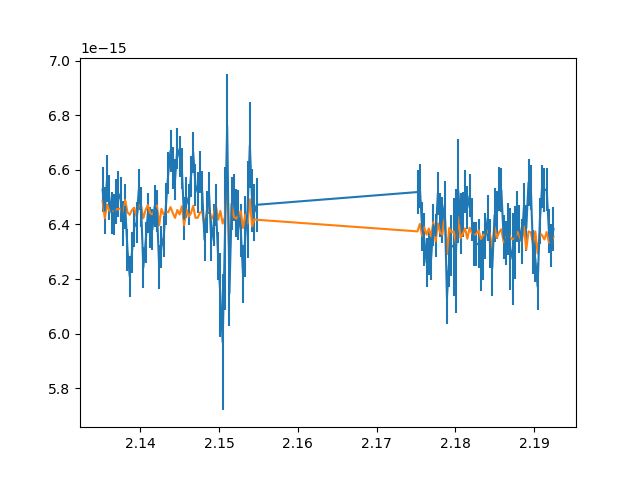

6.40460613516e-15
1.01613542692e-16
63.029060551


<IPython.core.display.Javascript object>


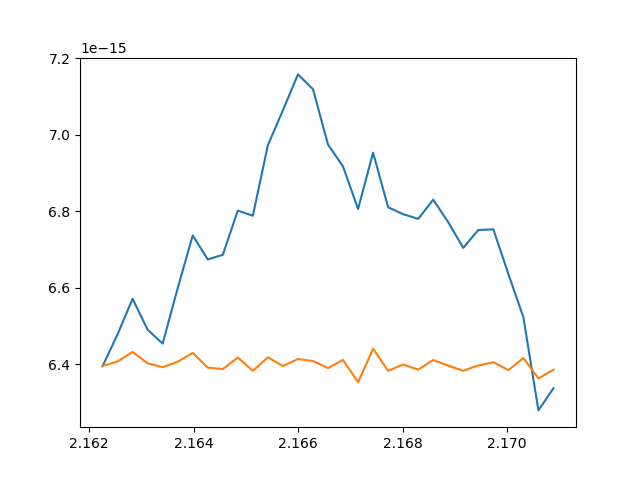

eq width (angstroms): -4.6076109427
log(eq width (angstroms)): 0.66347580102
pixels 31
wavespace: 86.3289834
h_lambda: 2.78480591613
f*/fc 1.05152696813
unc. eq width (angstroms): 0.252258119271
fractional uncertainty: 0.0547481378979
continuum level: 6.39941096757e-15 1.01531117735e-16
fractional uncertainty: 0.0158656973665
line flux (W/m2): 2.9485996001e-18 1.68072219388e-19
line flux (erg/s/cm2): 2.9485996001e-15 1.68072219388e-16
-14.5303841977

-5.61892539446 0.0179260034791
-6.02319019296 0.0252264725991
Pa $\beta$:
Eq. Width: -3.95832861791 0.149651700569
Line flux: 7.47963836922e-18 2.97197234883e-19
log$_{10}$ L/Lsol: -5.61892539446 0.0179260034791
log$_{10}$ Lacc/Lsol: -3.25557494968 1.07007900354

Br $\gamma$:
Eq. Width: -4.6076109427 0.252258119271
Line flux: 2.9485996001e-18 1.68072219388e-19
log$_{10}$ L/Lsol: -6.02319019296 0.0252264725991
log$_{10}$ Lacc/Lsol: -3.15921964313 1.39096215421

Accretion luminosity: -3.2197505854 1.17905281308

-3.64173853646 1.14170366425


<IPython.core.display.Javascript object>


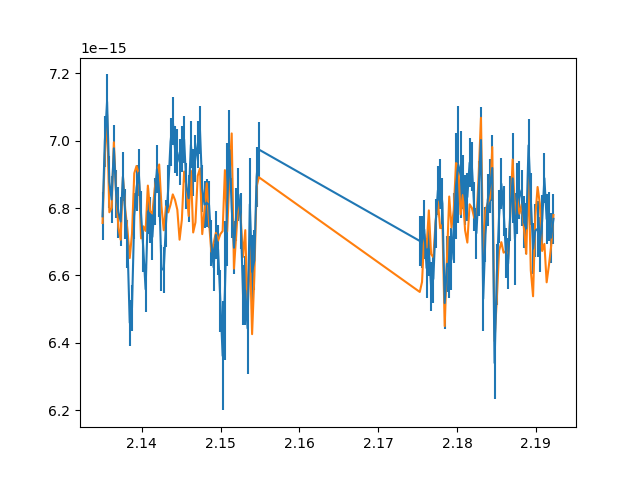

6.76788380287e-15
1.07449530776e-16
62.9866296668


<IPython.core.display.Javascript object>


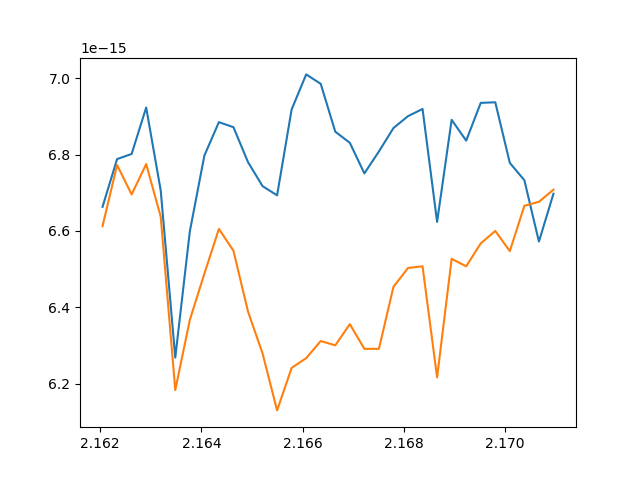

eq width (angstroms): -4.63940402858
log(eq width (angstroms)): 0.66646219527
pixels 32
wavespace: 89.1113281
h_lambda: 2.78472900313
f*/fc 1.05052880588
unc. eq width (angstroms): 0.256338323415
fractional uncertainty: 0.0552524250607
continuum level: 6.46345677127e-15 1.02616329933e-16
fractional uncertainty: 0.0158763852787
line flux (W/m2): 2.99865873832e-18 1.72387413613e-19
line flux (erg/s/cm2): 2.99865873832e-15 1.72387413613e-16
-14.5230729562

-5.61426572788 0.0181390671642
-6.01587895147 0.025434259404
Pa $\beta$:
Eq. Width: -3.96289195273 0.151727759354
Line flux: 7.56032155687e-18 3.04254338016e-19
log$_{10}$ L/Lsol: -5.61426572788 0.0181390671642
log$_{10}$ Lacc/Lsol: -3.25026292978 1.06945737702

Br $\gamma$:
Eq. Width: -4.63940402858 0.256338323415
Line flux: 2.99865873832e-18 1.72387413613e-19
log$_{10}$ L/Lsol: -6.01587895147 0.025434259404
log$_{10}$ Lacc/Lsol: -3.15000747885 1.38982548724

Accretion luminosity: -3.2129774405 1.17984186494

-3.63540138991 1.140792598

<IPython.core.display.Javascript object>


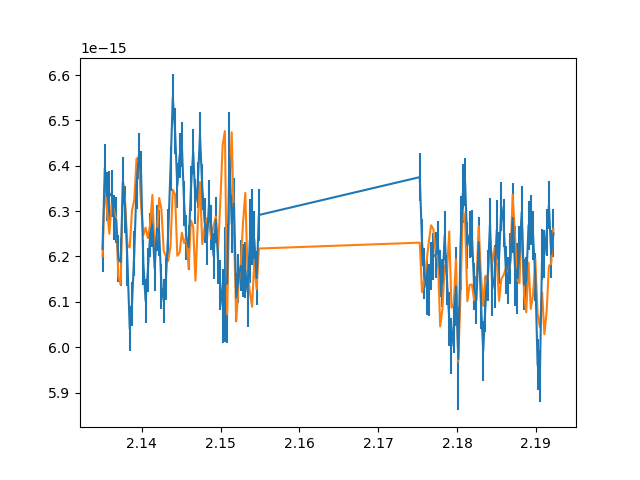

6.21449764831e-15
9.99791520148e-17
62.1579351603


<IPython.core.display.Javascript object>


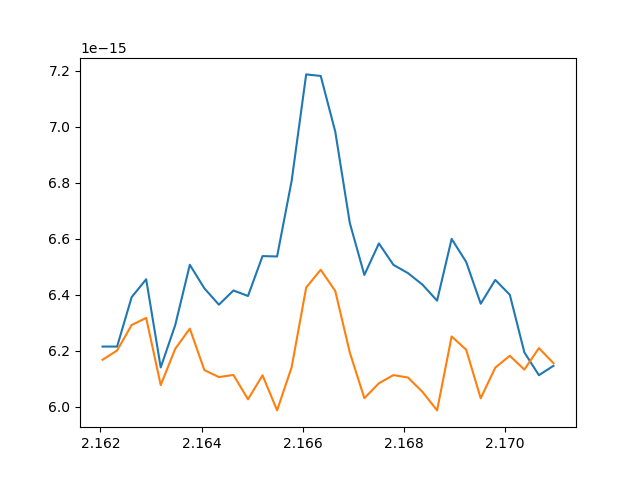

eq width (angstroms): -4.63937539595
log(eq width (angstroms)): 0.666459514962
pixels 32
wavespace: 89.1232491
h_lambda: 2.78510153437
f*/fc 1.05052526505
unc. eq width (angstroms): 0.259790157621
fractional uncertainty: 0.0559967960014
continuum level: 6.16735925933e-15 9.92207872322e-17
fractional uncertainty: 0.0160880505027
line flux (W/m2): 2.86126948057e-18 1.66703427043e-19
line flux (erg/s/cm2): 2.86126948057e-15 1.66703427043e-16
-14.5434412375

-5.62882564969 0.0186697904498
-6.03624723273 0.0257642526977
Pa $\beta$:
Eq. Width: -3.97245333461 0.156697817351
Line flux: 7.31105995807e-18 3.03485549064e-19
log$_{10}$ L/Lsol: -5.62882564969 0.0186697904498
log$_{10}$ Lacc/Lsol: -3.26686124064 1.07142668986

Br $\gamma$:
Eq. Width: -4.63937539595 0.259790157621
Line flux: 2.86126948057e-18 1.66703427043e-19
log$_{10}$ L/Lsol: -6.03624723273 0.0257642526977
log$_{10}$ Lacc/Lsol: -3.17567151324 1.39301958899

Accretion luminosity: -3.23296675585 1.17747370308

-3.65520288357 1.14367

In [67]:
print 'AWI0005x3s, 2017-11-04'
get_accretion_luminosities(awi0005x3s_20171104_2mass_highsnr, awi0005x3s_xtc_20171104_2massweighted_normalized, 9.8599, 0.0551)
print ''

print 'AWI0005x3s, 2018-03-01'
get_accretion_luminosities(awi0005x3s_20180301_highsnr,awi0005x3s_xtc_20171104_2massweighted_normalized, 9.8599, 0.0551)
print ''

print 'AWI0005x3s, 2018-03-02'
get_accretion_luminosities(awi0005x3s_20180302_highsnr,awi0005x3s_xtc_20171104_2massweighted_normalized, 9.8599, 0.0551)
print ''